Bank will score debts based on many factors to assess the expected recovery amount.

The higher the score, the more the bank will pursue the debt.
(Higher amount that the bank may be able to receive from the customer in the future.)

Bank has different strategies at different threshold, each level will cost $50 more than the prior level.

Is this worth it?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('bank_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1882 non-null   int64  
 1   expected_recovery_amount  1882 non-null   int64  
 2   actual_recovery_amount    1882 non-null   float64
 3   recovery_strategy         1882 non-null   object 
 4   age                       1882 non-null   int64  
 5   sex                       1882 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 88.3+ KB


EDA
    expected_recovery_amount vs actual_recovery_amount
    recovery_strategy vs recovery_surplus (actual - expected)
    age, sex vs recovery_strategy

In [4]:
# change data types
# recovery_strategy and sex --> category
df.recovery_strategy = df.recovery_strategy.astype('category')
df.sex = df.sex.astype('category')
df.dtypes

id                             int64
expected_recovery_amount       int64
actual_recovery_amount       float64
recovery_strategy           category
age                            int64
sex                         category
dtype: object

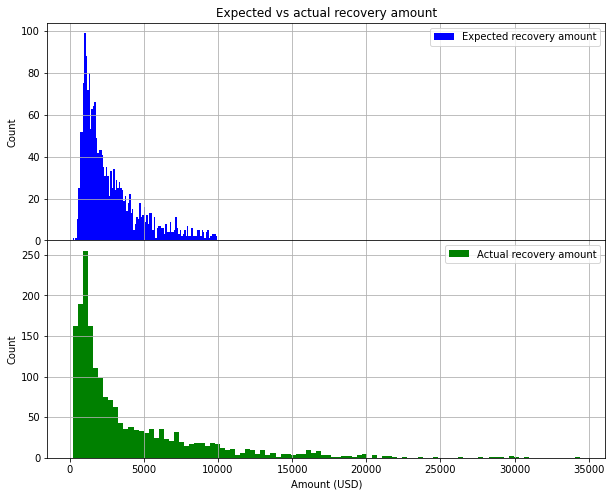

In [5]:
# histograms for expected and actual recovery amount
fig, (ax1, ax2) = plt.subplots(2, figsize =(10,8), sharex=True)

fig.subplots_adjust(hspace=0)

df.expected_recovery_amount.hist(ax=ax1, bins=100, color='blue', label='Expected recovery amount')
df.actual_recovery_amount.hist(ax=ax2, bins=100, color='green', label='Actual recovery amount')

ax1.set(title='Expected vs actual recovery amount', ylabel='Count')
ax2.set(xlabel='Amount (USD)',ylabel='Count')
ax1.legend()
ax2.legend()

plt.show()

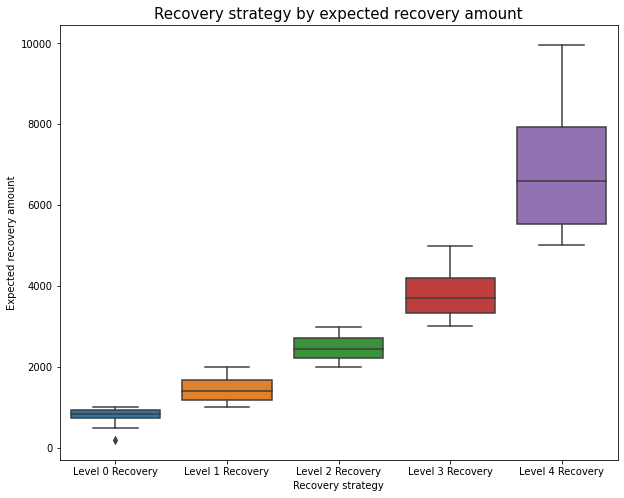

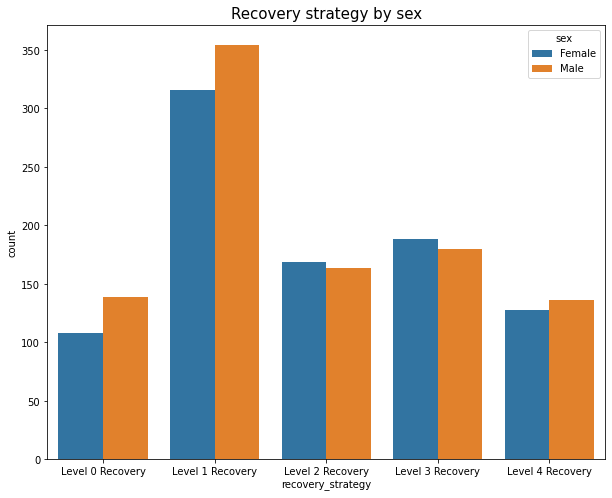

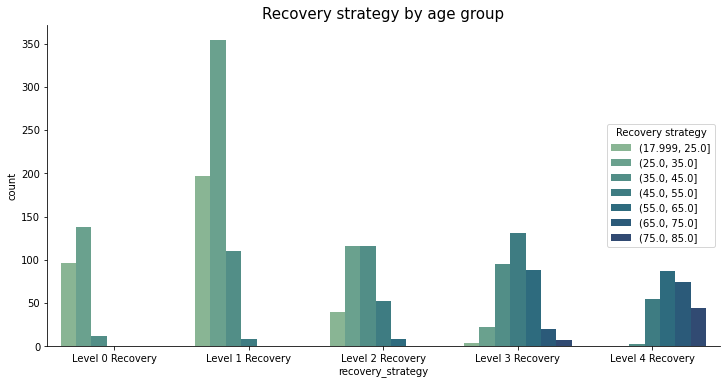

In [6]:
# How do strategies get assigned

# Recovery strategy by expected_recovery_amount
fig, ax = plt.subplots(figsize =(10,8))

sns.boxplot(data=df, y='expected_recovery_amount', x='recovery_strategy', ax=ax)
ax.set_title('Recovery strategy by expected recovery amount', size=15)
ax.set_xlabel('Recovery strategy')
ax.set_ylabel('Expected recovery amount')

plt.show()

# Recovery strategy by sex
fig, ax1 = plt.subplots(figsize =(10,8))
ax1.set_title('Recovery strategy by sex', size=15)
sns.countplot(data=df, x='recovery_strategy', hue='sex', ax=ax1)

plt.show()

# Recovery strategy by age

# categorize age groups
df['age_group'] = pd.cut(df.age, bins=[18,25,35,45,55,65,75,85], include_lowest=True)

sns.catplot(data=df, x='recovery_strategy', hue='age_group', kind='count', legend=False, palette='crest', height=5, aspect=2)
plt.title('Recovery strategy by age group', size=15)
plt.legend(title='Recovery strategy', loc='right')

plt.show()

In [7]:
df.recovery_strategy.value_counts().sort_index()

Level 0 Recovery    247
Level 1 Recovery    670
Level 2 Recovery    333
Level 3 Recovery    368
Level 4 Recovery    264
Name: recovery_strategy, dtype: int64

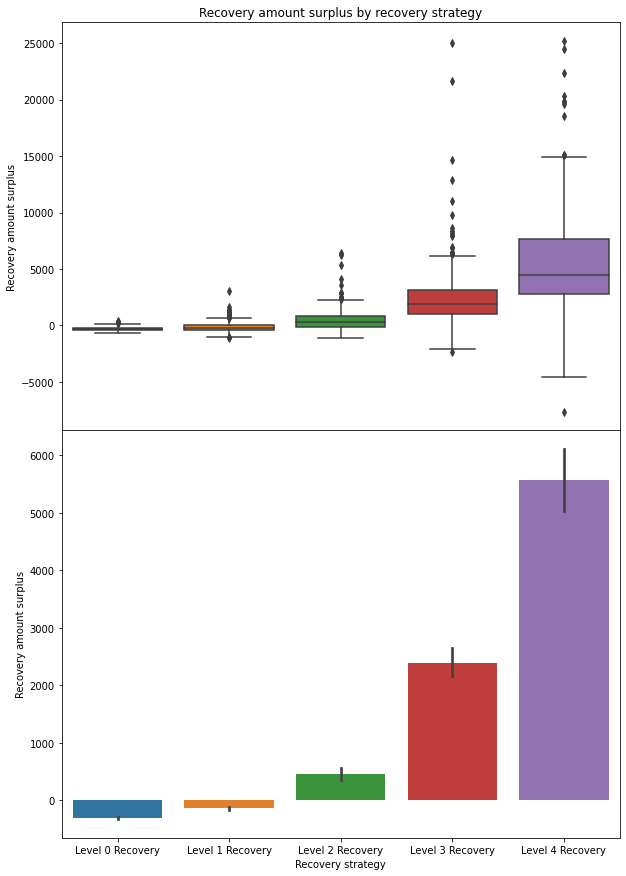

In [8]:
# Do strategies with higher costs get more money back?

# create new cols: recovery_amount_surplus, recovery_cost
df['recovery_amount_surplus'] = df.actual_recovery_amount - df.expected_recovery_amount

fig, (ax3, ax4) = plt.subplots(2, figsize =(10,15), sharex=True)
fig.subplots_adjust(hspace=0)

sns.boxplot(data=df, x='recovery_strategy', y='recovery_amount_surplus', ax=ax3)
ax3.set(title='Recovery amount surplus by recovery strategy', ylabel='Recovery amount surplus')
sns.barplot(data=df, x='recovery_strategy', y='recovery_amount_surplus', ax=ax4)
ax4.set(xlabel='Recovery strategy', ylabel='Recovery amount surplus')


plt.show()

In [9]:
# let's see the numbers
df.groupby('recovery_strategy')['recovery_amount_surplus'].mean().sort_index()

recovery_strategy
Level 0 Recovery    -304.345344
Level 1 Recovery    -140.382313
Level 2 Recovery     461.744170
Level 3 Recovery    2388.967504
Level 4 Recovery    5575.344960
Name: recovery_amount_surplus, dtype: float64

Question about the data:
    Are there differences in different strategies?

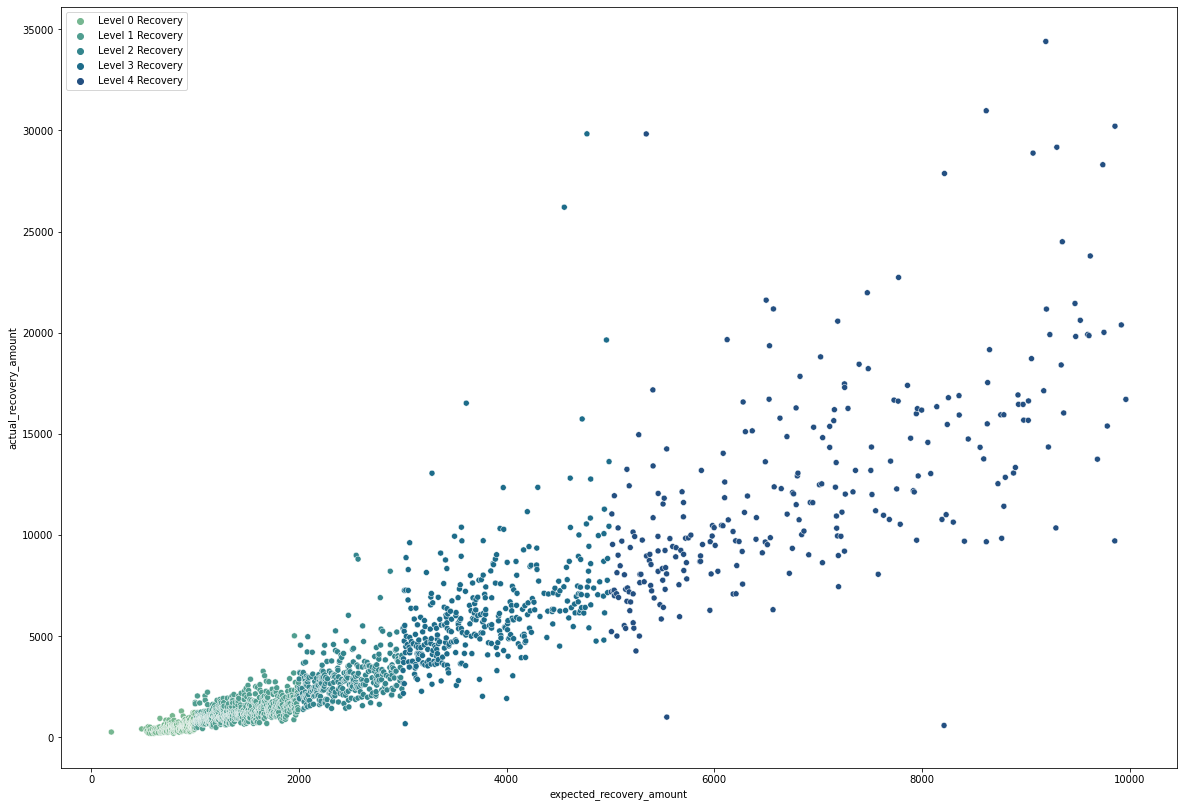

In [10]:
# scatterplot between expected and actual recovery amount
fig, ax = plt.subplots(figsize=(20,14))
sns.scatterplot(data=df, x='expected_recovery_amount', y='actual_recovery_amount', ax=ax, 
               hue='recovery_strategy', palette='crest')
plt.legend(loc='upper left')
plt.show()

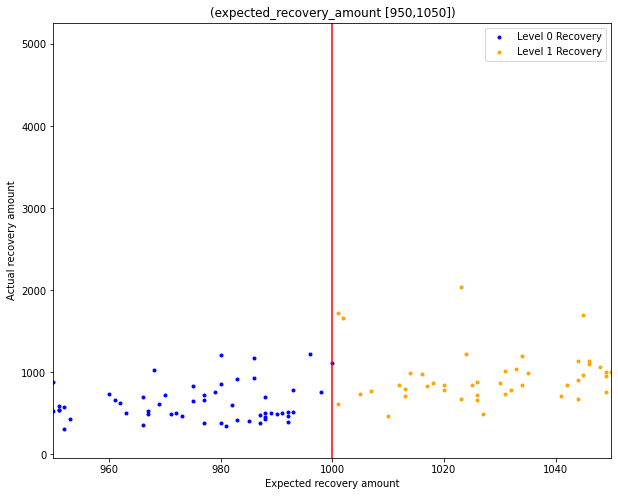

In [60]:
# visualize discontinuty between Level 0 & 1
fig, ax = plt.subplots(figsize=(10,8))

strat_color = [('Level 0 Recovery','blue'), ('Level 1 Recovery','orange')]

for s,c in strat_color:
    data = df[df.recovery_strategy == s]
    ax.scatter(data.expected_recovery_amount, data.actual_recovery_amount, marker='.', color=c, label=s)

# zoom in and add line at the threshold
ax.set_title("(expected_recovery_amount [950,1050])")
ax.set_xlim([950,1050]) 
ax.set_xlabel("Expected recovery amount")
ax.set_ylabel("Actual recovery amount")
ax.axvline(x=1000, color='r')    
 
plt.legend()
plt.show()

Observed mean age differece = 2.2040404040404056
empirical two-sided pvalue = 0.08826


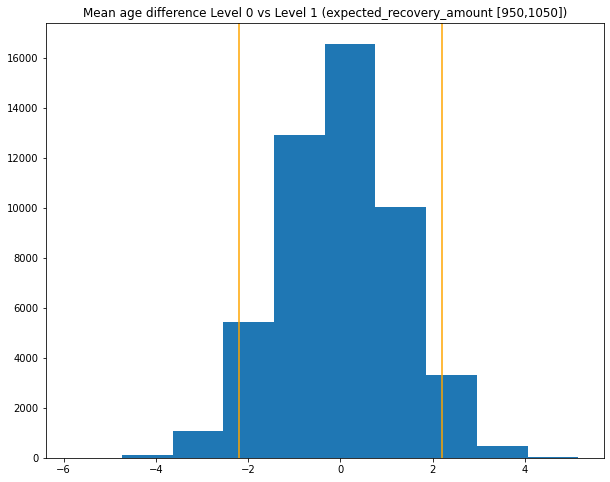

In [61]:
# by eye, not that different in terms of actual_recovery_amount

# clarify that both sex and age is not statistically different between lv 0 & 1
# though it's quite similar based on our graphical EDA
# let's do a statistical test
    # two samples stats

# focus on data near the $1000 threshold
df_0 = df[df.recovery_strategy == 'Level 0 Recovery']
df_1 = df[df.recovery_strategy == 'Level 1 Recovery']
df_0 = df_0[(df_0.expected_recovery_amount <= 1050) & (df_0.expected_recovery_amount >= 950)]
df_1 = df_1[(df_1.expected_recovery_amount <= 1050) & (df_1.expected_recovery_amount >= 950)]

# Age
# null hyp: no difference
# test statistic is the mean difference

# calculate observed mean difference
mean_age_diff_obs = df_1.age.mean() - df_0.age.mean()
print("Observed mean age differece =", mean_age_diff_obs)

# generate permutation samples and permutation replicates
ages = np.array(list(df_0.age) + list(df_1.age))
# ages = np.array(df[(df.expected_recovery_amount <= 1050) & (df.expected_recovery_amount >= 950)].age)
perm_repl = np.empty(50000)
for i in range(50000):
    perm = np.random.permutation(ages)
    temp_0 = perm[:len(df_0)]
    temp_1 = perm[len(df_0):]
    perm_repl[i] = np.mean(temp_1) - np.mean(temp_0)

# get pvalue
print("empirical two-sided pvalue =", (np.sum(perm_repl >= mean_age_diff_obs) + np.sum(perm_repl <= -1*mean_age_diff_obs)) \
      / len(perm_repl))

# compare on plot
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Mean age difference Level 0 vs Level 1 (expected_recovery_amount [950,1050])")
ax.hist(perm_repl)
ax.axvline(x=mean_age_diff_obs, c='orange')
ax.axvline(x=-1*mean_age_diff_obs, c='orange')
plt.show()

Observed male ratio difference = -0.02626262626262621
empirical two-sided pvalue = 0.8442


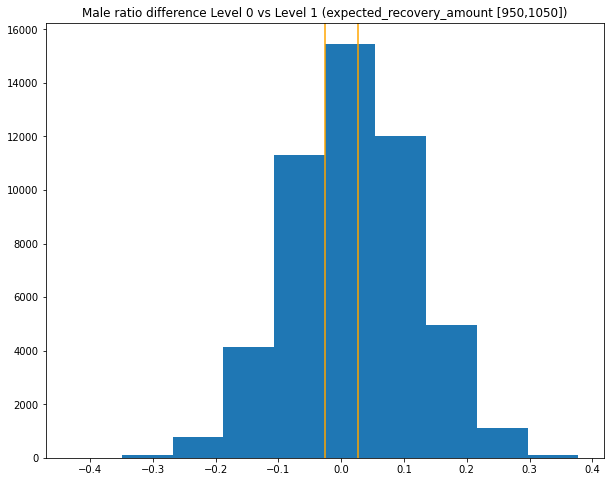

In [62]:
# do the similar for sex
# male ratio vs recovery strategy

# Sex
# null hyp: male ratio in both groups are the same
# test statistic is the male ratio

# calculate observed male ratio
male_ratio_obs = (df_1.sex == 'Male').mean() - (df_0.sex == 'Male').mean()
print("Observed male ratio difference =", male_ratio_obs)

sexes = np.array(list(df_0.sex) + list(df_1.sex))

# generate permutation samples and permutation replicates
sexes = np.array(list(df_0.sex) + list(df_1.sex))
perm_repl = np.empty(50000)
for i in range(50000):
    perm = np.random.permutation(sexes)
    temp_0 = perm[:len(df_0)]
    temp_1 = perm[len(df_0):]
    perm_repl[i] = np.mean(temp_1 == 'Male') - np.mean(temp_0 == 'Male')

# get pvalue    
print("empirical two-sided pvalue =",
      # male_ratio_obs is n'ive
      (np.sum(perm_repl <= male_ratio_obs) + np.sum(perm_repl >= -1*male_ratio_obs)) \
      / len(perm_repl))

# compare on plot
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Male ratio difference Level 0 vs Level 1 (expected_recovery_amount [950,1050])")
ax.hist(perm_repl, bins=10)
ax.axvline(x=male_ratio_obs, c='orange')
ax.axvline(x=-1*male_ratio_obs, c='orange')
plt.show()

Observed recovery amount surplus difference 269.9232363428282
p-value: 0.0


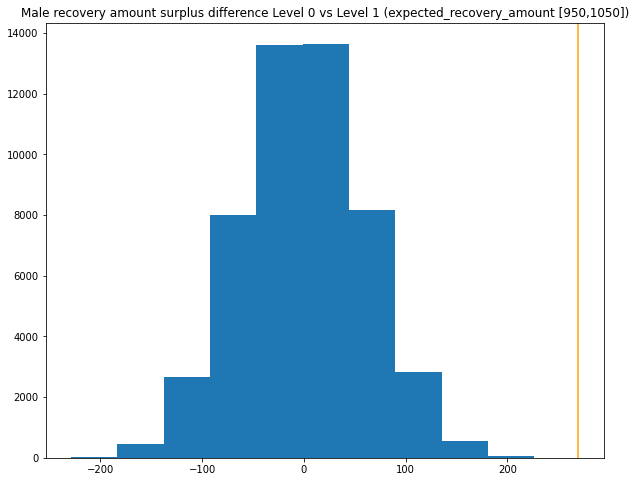

In [75]:
# no statistical difference among the two groups for sex and age
# so the underlying factor should be narrowed down to the recovery_strategy

# Actual recovery amount
# null hyp: no recovery amount surplus difference
# test statistic is recovery_amount_surplus difference

# observed stat
# mean_ara_diff_obs = df_1.actual_recovery_amount.mean() - df_0.actual_recovery_amount.mean()
mean_ras_diff_obs = df_1.recovery_amount_surplus.mean() - df_0.recovery_amount_surplus.mean()
print('Observed recovery amount surplus difference', mean_ras_diff_obs)

# generate permutation samples and permutation replicates
ras = np.array(list(df_0.recovery_amount_surplus) + list(df_1.recovery_amount_surplus))
perm_repl = np.empty(50000)
for i in range(50000):
    perm = np.random.permutation(ras)
    temp_0 = perm[:len(df_0)]
    temp_1 = perm[len(df_0):]
    perm_repl[i] = np.mean(temp_1) - np.mean(temp_0)

# get p-value (one sided)
print('p-value:', np.sum(perm_repl >= mean_ras_diff_obs) / len(perm_repl))

# compare on plot
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Male recovery amount surplus difference Level 0 vs Level 1 (expected_recovery_amount [950,1050])")
ax.hist(perm_repl, bins=10)
ax.axvline(x=mean_ras_diff_obs, c='orange')
plt.show()

Near the $1000 threshold, with era between $950 and $1050, recovery strategy Level 1 outperformed Level 0 by receiving $270 recovery amount surplus.

The difference in recovery amount surplus between the two levels is statistically significant.

There is a treatment effect between Level 0 and Level 1
We should try implement Level 1 recovery strategy to loans with era < $1000 also, at least until $950 as the data suggests